# Helper Functions

## These functions are to be called upon in other notebooks

In [18]:
# Import all relevant modules

import numpy as np
import matplotlib.pyplot as plt

import random

import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15

from astropy.cosmology import z_at_value

from PIL import Image
from PIL import ImageDraw

In [19]:
def hubble_time_steps():
    '''
    Function that generates a list of all the times that indicate 
    the beginning of a new Hubble expansion time.
    
    These times will correspond to the time at which wakes are generated for that Hubble expansion time
    '''
    
    hubble_list = [0]*16
    hubble_list[0] += 370000 # Time of recombination (in years)
    
    for i in range(len(hubble_list)):
        if i == 0:
            continue
        else:
            hubble_list[i] += hubble_list[i-1] * 2 # Formula for computing time steps
            
    return hubble_list


In [20]:
def hubble_angular_distances():
    '''
    Function that generates a list of all the Hubble comoving distances
    for the beginning of each Hubble expansion time
    
    These values give the relative size of a Hubble volume as seen by
    an observer on Earth today
    '''
    
    distance_list = [0]*16
    distance_list[0] += 1.8 # Angular size of universe at t_{rec} (degrees)
    
    for i in range(len(distance_list)):
        
        if i == 0:
            continue
            
        else:
            distance_list[i] += distance_list[i-1] * 2**(1/3) # Formula for angular distance
    
    return distance_list



In [21]:
def hubble_pixel_size(H, map_size):
    '''
    Function that returns the pixel size of the observable universe at the Hth time step 
    as a function of the total pixel size of the map (for this project, 400x400)
    '''
    
    return (hubble_angular_distances()[H] * map_size)/10


In [22]:
## Paste constants in their natural unit form

thomson_cross_section = 6.652e-29 * (1/(0.1973e-15))**2 

ionization_fraction = 1e-3

string_tension = 3e-7

baryon_fraction = 0.2

planck_mass = 1.221e19

inverse_proton_mass = 1/(1.6726e-27) * 1.7827e-27

current_time = 4.361e17 * 1/(6.5823e-25)


In [23]:
def convert_unit(value, init_unit):
    '''
    Converts an initial unit to its equivalent in natural units
    '''
    
    if init_unit == 'g':
        return value * 5.62e23 #GeV
    
    elif init_unit == 'K':
        return value * 8.62e-14 #GeV
    
    elif init_unit == 's':
        return value * 1/6.5823e-25 #GeV^-1
    
    elif init_unit == 'm':
        return value * 1/1.9733e-16 #GeV^-1
    
    elif init_unit == 'm2':
        return value * 3.8938e-32 #GeV^-2
    
    elif init_unit == 'g/cm^3':
        return value * 5.62e23 * (1.98e-14)**3
    
    else:
        return None

In [24]:
def get_rect(x, y, depth, length, angle):
    '''
    Function that generates a rectangle onto a 2D numpy array 
    This will be used to produce the general shape of the signal from a cosmic string wake
    '''
    rect = np.array([(0, 0), (depth, 0), (depth, length), (0, length), (0, 0)])
    theta = (np.pi / 180.0) * angle
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    offset = np.array([x, y])
    transformed_rect = np.dot(rect, R) + offset
    
    return transformed_rect

In [34]:
class CosmicString:
    '''
    Condense all the characteristics of a cosmic string into a
    class
    '''
    
    def __init__(self, time_step, photon_time):
        
        '''
        The __init__ function initializes all relevant cosmic string parameters
        '''
        
        # Initialize string length:
        
        self.c1 = random.uniform(0.1,1) 
        
        self.time = hubble_time_steps()[time_step] 
        
        self.length = self.c1 * convert_unit(self.time * 3.154e7, 's') 
        
        # Initialize string depth:
        
        self.velocity = random.random() 
        
        gamma = 1/(np.sqrt(1- self.velocity**2)) 
        
        self.vsgammas = self.velocity * gamma
        
        self.depth = convert_unit(self.time * 3.154e7, 's') * self.velocity * gamma 
        
        # Initalize angles:
        
        self.theta = random.uniform(0, np.pi/2)
        
        self.photon_time = hubble_time_steps()[photon_time]
        
        # Initialize parameters for height of wake:
        
        self.wake_redshift = z_at_value(Planck15.age, self.time * u.year, zmax=1100)

        self.photon_redshift = z_at_value(Planck15.age, self.photon_time * u.year, zmax=1100)

        self.height = 24*np.pi/5 * string_tension * self.velocity * gamma * (self.wake_redshift + 1)**(-1/2) * \
        current_time * ((self.wake_redshift)+1)/((self.photon_redshift + 1)**2)
        
        # Initialize other parameters:
        
        self.angular_distance = hubble_angular_distances()[time_step] # Units of degrees
        
        
        ##############################################################################################
        
        
        # Initialize parameters to compute polarization signal:
        
        numerator = 0
        
        # Choose whether the wake presents its length or depth in the bird's eye view:
        self.length_depth_choice = random.choice([True, False])

        if self.length_depth_choice:
            numerator += self.length
        else:
            numerator += self.depth
            
        # Compute the critical angle theta:
        theta_crit = np.arctan(numerator/(2*self.height))
        
        # Distance (l) that photons travel through the wake

        l = 0
    
        if self.theta <= theta_crit:
            l += 2*self.height/np.cos(self.theta)
        else:
            l += numerator/np.sin(self.theta)
            
        self.l = l
         
        # Average polarization signal (P/Q)
        
        self.polarization_signal = 1/10 * (3/(4*np.pi))**(1/2) * thomson_cross_section * l * ionization_fraction * \
        baryon_fraction * (2/(3*convert_unit(self.time * 3.154e7, 's')))**2 * planck_mass**2 * inverse_proton_mass * \
        ((self.photon_redshift + 1)**4)/((self.wake_redshift + 1)**3)
        
        
        ####################################################################################
    
    
    def map_signal(self, length, depth, map_size):
        '''
        Function that draws a wake signal with a certain length and depth on a map of size = map_size
        '''
        
        im_list = []
        zeros = np.zeros((map_size,map_size))
    
        signal = np.array([2*self.polarization_signal/depth]*depth)
        
        angle = np.random.uniform(0, 90)
        
        x = round(np.random.uniform(0,map_size))
        y = round(np.random.uniform(0,map_size))


        for d in range(1, depth+1):
    
            rect = get_rect(x=x, y=y, depth=d, length=length, angle=angle)
    
            img = Image.fromarray(zeros)
            draw = ImageDraw.Draw(img)
            draw.polygon([tuple(p) for p in rect], fill=signal[d-1])
            im_list.append(np.asarray(img))
    
        final_signal = np.zeros((map_size, map_size))
        
        for i in im_list:
            final_signal += i
        
        # Determine whether signal is "flipped"
        
        left_right_choice = np.random.choice([True, False])
    
        if left_right_choice:
            zeros_copy = np.zeros((map_size, map_size))
        
            for i,c in enumerate(final_signal):
                zeros_copy[i] += np.flip(c)
                
            return zeros_copy
        
        else:
            
            return final_signal


## Below is some code that was helpful for me to understand and write the code for the double sum presented in the Scaling_Solution_Signal.ipynb notebook. I will leave it here, but everything below this paragraph is essentially useless and could be deleted without affecting the rest of the programs.

C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in double_scalars


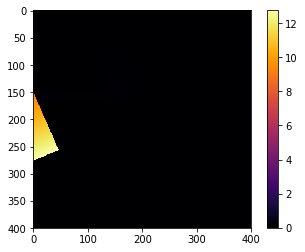

In [26]:
# Start at trec
# At trec, pixel size of the obs. universe is:

trec_size = hubble_pixel_size(0, 400)

# For N=3, the total number of wakes perceived is:

trec_N = int( 10**2 / hubble_angular_distances()[0]**2 * 3)

# So, photons crossing wakes at trec intersect trec_N wakes, all of which were layed down at trec

signal_list = []
for i in range(0, trec_N):
    a = CosmicString(0, 0)
    
    adjust_length = int(round(hubble_pixel_size(0, 400) * a.c1))
    adjust_width = int(round(hubble_pixel_size(0, 400) * a.vsgammas))
    
    signal_list.append(a.map_signal(adjust_length, adjust_width, 400))
    

plt.imshow(sum(signal_list), cmap='inferno')
plt.colorbar()
plt.show()




/Users/jadeducharme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in double_scalars


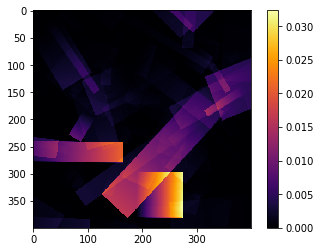

In [10]:
# Now, we are at t1
# At t1, the size of the observable universe is:

t1_size = hubble_pixel_size(1, 400)

# For N=3, the total amount of wakes LAYED DOWN at t1 is:

t1_N = int(10**2 / hubble_angular_distances()[1]**2 * 3)

# Photons crossing at t1 intersect t1_N wakes layed down at t1
# They also cross a certain number of wakes layed down at trec
# That number is EQUAL to t1_N
# So, photons cross an equal amount of wakes generated at trec and t1

signal_list = []

for i in range(0, t1_N):
    a = CosmicString(1,1)
    
    adjust_length = int(round(hubble_pixel_size(1, 400) * a.c1))
    adjust_width = int(round(hubble_pixel_size(1, 400) * a.vsgammas))
    
    signal_list.append(a.map_signal(adjust_length, adjust_width, 400))
    
for i in range(0, t1_N):
    a = CosmicString(0,1)
    
    adjust_length = int(round(hubble_pixel_size(0, 400) * a.c1)) # Their size is determined by their birth?
    adjust_width = int(round(hubble_pixel_size(0, 400) * a.vsgammas))
    
    signal_list.append(a.map_signal(adjust_length, adjust_width, 400))
    
    
plt.imshow(sum(signal_list), cmap='inferno')
plt.colorbar()
plt.show()

/Users/jadeducharme/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in double_scalars


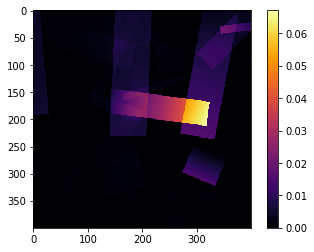

In [11]:
# One last time to make sure I get the hang of it
# Now, we are at t2
# The size of the observable universe is:

t2_size = hubble_pixel_size(2, 400)

# For N=3, the total amount of wakes LAYED DOWN at t1 is:

t2_N = int(10**2 / hubble_angular_distances()[2]**2 * 3)

# So, photons crossing wakes at t2 will cross t2_N wakes layed down at t2
# They will also cross t2_N wakes layed down at t1
# And they will cross t2_N wakes layed down at trec

signal_list = []

for i in range(0, t2_N):
    
    a = CosmicString(2, 2)
    
    adjust_length = int(round(hubble_pixel_size(2, 400) * a.c1)) # Their size is determined by their birth?
    adjust_width = int(round(hubble_pixel_size(2, 400) * a.vsgammas))
    
    signal_list.append(a.map_signal(adjust_length, adjust_width, 400))
    
for i in range(0, t2_N):
    
    a = CosmicString(1, 2)
        
    adjust_length = int(round(hubble_pixel_size(1, 400) * a.c1)) # Their size is determined by their birth?
    adjust_width = int(round(hubble_pixel_size(1, 400) * a.vsgammas))
    
    signal_list.append(a.map_signal(adjust_length, adjust_width, 400))
    
for i in range(0, t2_N):
    
    a = CosmicString(0, 2)
        
    adjust_length = int(round(hubble_pixel_size(0, 400) * a.c1)) # Their size is determined by their birth?
    adjust_width = int(round(hubble_pixel_size(0, 400) * a.vsgammas))
    
    signal_list.append(a.map_signal(adjust_length, adjust_width, 400))
    
    
plt.imshow(sum(signal_list), cmap='inferno')
plt.colorbar()
plt.show()